# NJIT Fall 2024 CS634: Data Mining Final Project #
## Joshua Kobuskie ##
### November 17, 2024 ###

##### Supervised Data Mining (Classification) Binary Classification Only #####

Implement 3 different classification algorithms in Python. One of them is Random
Forest , the second one is from the deep learning list in the “Appendix → Additional
Option: Deep Learning”, and the third is from the list of algorithms in “Appendix →
Additional Option: Algorithms” on 1 dataset of your choice (each of the three
algorithms must run on the same dataset).

NOTE: This is not from scratch implementation, just use the existing libraries
to implement the algorithms, but the performance metrics must be calculated
manually. You may use “confusion_matrix” library to get TP, TN, FP, FN ONLY,
then calculate the FPR, FNR, etc.… using the formulas from the slides.

Sources of data are listed in the Appendix “Additional Option: Sources of Data” or use
your own.

Your final term project documentation must clearly indicate the algorithms and dataset
you used in the project.

The classification algorithms that I have chosen to implement and evaluate in this project are the Random Forest, the UNDECIDED, and the UNDECIDED.<br>
The dataset I have chosen to use in this project is Kddcup 99 dataset from the scikit-learn real world datasets. This dataset contains TCP network connection data with about 5 million training records and 2 million test records. Each record is labelled as normal, or as a specific attack type. To ensure that this data will meet the criteria for binary classification used in this project, the data will be seperated into 2 classes of either normal or attack, rather than the specific classes of attacks detailed within the dataset. This also mimicks the intention of the dataset, as the training data contains 24 types of attack, but the test data contains an additonal 14 types of attacks not previously seen in the training data. This will test the models ability to detect known and unknown attacks based on its understnading of normal records. The models I will implment will be able to classify records as either normal TCP network connection data or abnormal TCP network connection data indicative of an attack.

In addition to the general submission rules and grading, include the websites where the
software and complete dataset can be downloaded.

The scikit-learn software can be downloaded at the following link: https://scikit-learn.org/stable/install.html <br>
The Kddcup 99 dataset can be downloaded in its entirety at the following link: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [1]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dataset = fetch_kddcup99(as_frame=True).frame
for col in dataset.iloc[0]:
    print(type(col))
print(dataset["labels"].value_counts())

<class 'int'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'int'>
<class 'int'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'bytes'>
labels
b'smurf.'              280790
b'neptune.'            107201
b'normal.'              97278
b'back.'                 2203
b'satan.'                1589
b'ipsweep.'              1247
b'portsweep.'            1040
b'warezclient.'          1020
b'teardrop.'              979
b'pod.'                   264
b'nmap.'                  231
b'guess_passwd.'           53
b'buffe

This dataset contains all the data needed for classification, but currently stores all of the protocol_type, service, flag, and labels as bytes. These values will be encoded into ints for training and testing. This data also presents a multiclassification problem. To transform this into a binary classification problem, we will have two class labels of normal and attack. All non-normal labels will be considered an attack for training and testing purposes.

In [2]:
def transformEncode(col, dict, count):
    if col not in dict:
        dict[col] = count[0]
        dict[count[0]] = col
        count[0] += 1
    return dict[col]

def transformLabel(col):
    if col == b'normal.':
        return 0
    else:
        return 1


protocolDict = {}
#Must be a list so that a reference is passed and we can change the value outside the function
count = [0]
dataset["protocol_type"] = dataset["protocol_type"].apply(transformEncode, args=(protocolDict,count,))

serviceDict = {}
count = [0]
dataset["service"] = dataset["service"].apply(transformEncode, args=(serviceDict,count,))

flagDict = {}
count = [0]
dataset["flag"] = dataset["flag"].apply(transformEncode, args=(flagDict,count,))

#Normal will be 0, attack will be 1
labelDict = {b'normal':0, 0: b'normal', b'attack':1, 1:b'attack'}
dataset["labels"] = dataset["labels"].apply(transformLabel)

print(protocolDict)
print(serviceDict)
print(flagDict)
print(labelDict)

{b'tcp': 0, 0: b'tcp', b'udp': 1, 1: b'udp', b'icmp': 2, 2: b'icmp'}
{b'http': 0, 0: b'http', b'smtp': 1, 1: b'smtp', b'finger': 2, 2: b'finger', b'domain_u': 3, 3: b'domain_u', b'auth': 4, 4: b'auth', b'telnet': 5, 5: b'telnet', b'ftp': 6, 6: b'ftp', b'eco_i': 7, 7: b'eco_i', b'ntp_u': 8, 8: b'ntp_u', b'ecr_i': 9, 9: b'ecr_i', b'other': 10, 10: b'other', b'private': 11, 11: b'private', b'pop_3': 12, 12: b'pop_3', b'ftp_data': 13, 13: b'ftp_data', b'rje': 14, 14: b'rje', b'time': 15, 15: b'time', b'mtp': 16, 16: b'mtp', b'link': 17, 17: b'link', b'remote_job': 18, 18: b'remote_job', b'gopher': 19, 19: b'gopher', b'ssh': 20, 20: b'ssh', b'name': 21, 21: b'name', b'whois': 22, 22: b'whois', b'domain': 23, 23: b'domain', b'login': 24, 24: b'login', b'imap4': 25, 25: b'imap4', b'daytime': 26, 26: b'daytime', b'ctf': 27, 27: b'ctf', b'nntp': 28, 28: b'nntp', b'shell': 29, 29: b'shell', b'IRC': 30, 30: b'IRC', b'nnsp': 31, 31: b'nnsp', b'http_443': 32, 32: b'http_443', b'exec': 33, 33: b'exe

To prepare this dataset for training, we will seperate the X dimensions and the Y labels

In [3]:
X = dataset.iloc[:, 0:-1]
Y = dataset.iloc[:, -1]
print(X.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     494021 non-null  object
 1   protocol_type                494021 non-null  int64 
 2   service                      494021 non-null  int64 
 3   flag                         494021 non-null  int64 
 4   src_bytes                    494021 non-null  object
 5   dst_bytes                    494021 non-null  object
 6   land                         494021 non-null  object
 7   wrong_fragment               494021 non-null  object
 8   urgent                       494021 non-null  object
 9   hot                          494021 non-null  object
 10  num_failed_logins            494021 non-null  object
 11  logged_in                    494021 non-null  object
 12  num_compromised              494021 non-null  object
 13  root_shell    

In this dataset, there is an imbalance in the number of normal connections and attack connections with a bias toward attack connection data. This bias is visualized below

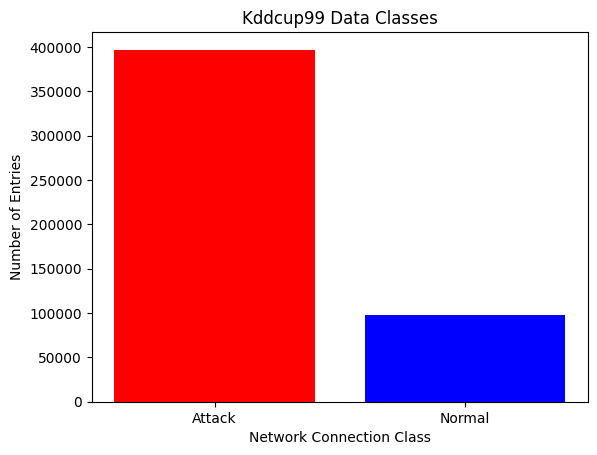

#################### Checking for Data Imbalance ####################
Attack Entries: 396743, Normal Entries: 97278, Total Entries: 494021
Attack Entries: 80.31%, Normal Entries: 19.69%


In [4]:
plt.bar(["Attack", "Normal"], Y.value_counts(), color=["red", "blue"])
plt.xlabel("Network Connection Class")
plt.ylabel("Number of Entries")
plt.title("Kddcup99 Data Classes")
plt.show()
print("#################### Checking for Data Imbalance ####################")
print("Attack Entries: {}, Normal Entries: {}, Total Entries: {}".format(Y.value_counts()[1], Y.value_counts()[0], Y.count()))
print("Attack Entries: {:.2f}%, Normal Entries: {:.2f}%".format(Y.value_counts()[1] / Y.count() * 100, Y.value_counts()[0] / Y.count() * 100))

To overcome this imbalance in data, either the normal data could be oversampled or the attack data could be undersampled. While these options would balance the dataset, the data mining techniques used in this project are able to effectively work with small imbalances in data and neither of these approaches are neccessary. To ensure that the classes are proportionally utilized during training and testing, a stratified sampling approach will be used during the train-test split. Addiotnally, when performing k-fold cross validation, a stratified approach will be used to maintain a proportional distribution of classes.

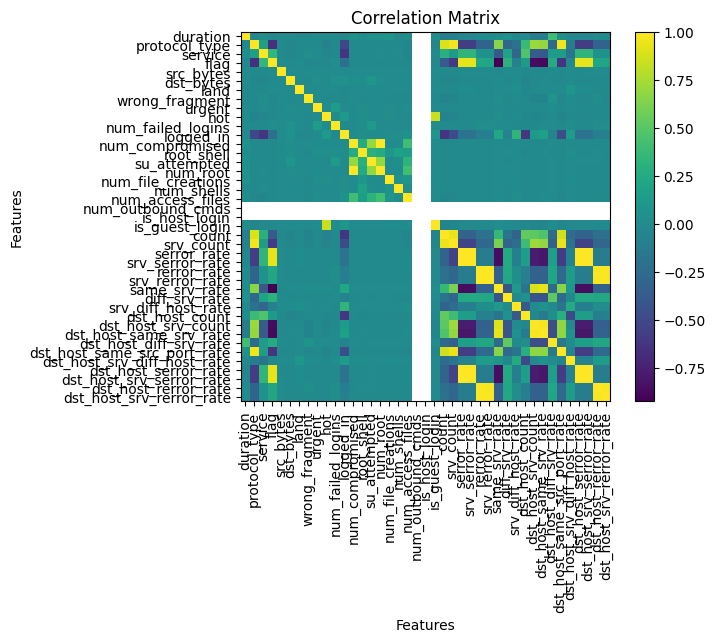

In [12]:
#create and display correlation matrix
corrMat = X.corr()
plt.imshow(corrMat)

plt.colorbar()

plt.title("Correlation Matrix") 
plt.xlabel("Features") 
plt.ylabel("Features")

plt.xticks(range(len(corrMat.columns)), corrMat.columns, rotation=90) 
plt.yticks(range(len(corrMat.columns)), corrMat.columns) 

plt.show()
